In [15]:
import os
import sys

from matplotlib import pyplot as plt
import matplotlib.patches as mpatch
import numpy as np
from scipy.integrate import dblquad
from scipy.stats import multivariate_normal

CWD = os.path.abspath("")
sys.path.append(os.path.join(CWD, ".."))
from plt_settings import plt_settings

full_width = 5.5
ratio = 1 / 1.618

In [17]:
ITERATIONS = int(1e6)
BURN_IN = int(5e5)

sampling_data = np.load(os.path.join(CWD, "2d_gaussian.npz"))
pdlmc_samples_all = sampling_data["pdlmc_x"]
pdlmc_samples = pdlmc_samples_all[BURN_IN:]
pdlmc_lambda = sampling_data["pdlmc_lambda"]
pdlmc_nu = sampling_data["pdlmc_nu"]

In [18]:
# True mean
Z, _ = dblquad(
    lambda y, x: multivariate_normal.pdf([x, y], mean=np.ones(2) * 2),
    -1,
    1,
    lambda x: -np.sqrt(1 - x**2),
    lambda x: np.sqrt(1 - x**2),
)
true_mean_x, _ = dblquad(
    lambda y, x: x * multivariate_normal.pdf([x, y], mean=np.ones(2) * 2),
    -1,
    1,
    lambda x: -np.sqrt(1 - x**2),
    lambda x: np.sqrt(1 - x**2),
)

true_mean = np.array([true_mean_x / Z, true_mean_x / Z])
print(f"Mean of the distribution: {true_mean}")

# Estimated mean
pdlmc_mean = pdlmc_samples.mean(axis=0)

print(f"Estimated mean via PD-LMC: {pdlmc_mean}")


# Out-of-support samples
out_of_support = ((pdlmc_samples * pdlmc_samples).sum(axis=1) > 1).mean()
print(f"Percentage of out-of-support samples: {out_of_support * 100:.2f}%")

# overestimation of boundary
pdlmc_samples_norm = (pdlmc_samples * pdlmc_samples).sum(axis=1)
pdlmc_boundary = np.logical_and(
    pdlmc_samples_norm >= 1 - 1e-3, pdlmc_samples_norm <= 1
).mean()

print(f"PD-LMC - Percentage of samples on boundary: {pdlmc_boundary * 100:.2f}%")

Mean of the distribution: [0.36799429 0.36799429]
Estimated mean via PD-LMC: [0.62184286 0.6178398 ]
Percentage of out-of-support samples: 25.53%
PD-LMC - Percentage of samples on boundary: 0.19%


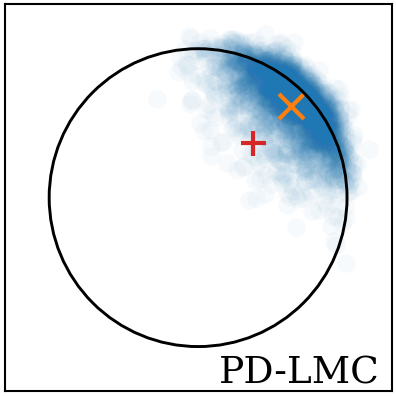

In [19]:
plt_settings["figure.figsize"] = (full_width, full_width / 4)
scatter_kwargs = {
    "s": 20.0,
    "edgecolors": "face",
    "alpha": 0.03,
    "linewidth": 0.0,
}

with plt.rc_context(plt_settings):
    _, ax = plt.subplots(dpi=300)
    ax.scatter(pdlmc_samples[::200, 0], pdlmc_samples[::200, 1], **scatter_kwargs)

    # for i, m in enumerate([pdlmc_mean, projlmc_mean, mirror_mean[0.001], rejection_mean]):
    ax.scatter(
        [pdlmc_mean[0]], [pdlmc_mean[1]], marker="x", color="C1", label="Estimated mean"
    )
    ax.scatter(
        [true_mean[0]], [true_mean[1]], marker="+", color="C3", label="True mean"
    )

    ax.add_artist(
        mpatch.Circle((0.0, 0.0), 1.0, facecolor="none", edgecolor="k", lw=0.7)
    )
    ax.set_xlim((-1.3, 1.3))
    ax.set_ylim((-1.3, 1.3))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1)
    ax.grid()

    # Title
    ax.set_title("PD-LMC", loc="right", x=0.97, y=0.02, pad=0)

    plt.show()